# 장애인콜택시 대기시간 예측
## 단계1.데이터 전처리

## 0.미션

* 1.데이터를 탐색하며 정보 획득
    * 데이터는 2015-01-01 ~ 2022-12-31 까지의 서울 장애인 콜택시 운행 정보입니다. 우리는 평균대기시간을 예측하고자 합니다. 
    * 요일, 월, 계절, 연도별 운행 정보에 어떤 주기와 변화가 있는지 탐색해 봅시다.
* 2.분석을 위한 데이터 구조 만들기
    * 문제정의 : 
        * 전 날 콜택시 운행이 종료되었을 때, 다음 날 대기시간을 예측하고자 합니다.

        * 만약 다음 날 대기시간을 예측할 수 있다면, 일정 범위 내에서 배차를 조절할 수 있을 뿐만 아니라, 향후 교통약자의 이동 편의 증진을 위한 정책 수립 및 개선에 기여할 수 있습니다. 
    * 이를 위한 데이터 구조를 만들어 봅시다.
        * 분석 단위는 일별 데이터 입니다.
        * 주어진 데이터 : 장애인 콜택시 운행 정보, 서울시 날씨
        * 날씨 데이터는 실제 측정값이지만, 다음 날에 대한 예보 데이터로 간주합니다. 
            * 예를 들어, 
                * 2020-12-23 의 날씨 데이터는 전 날(12월22일) 날씨예보 데이터로 간주하여 분석을 수행합니다.
                * 2020-12-22일의 장애인 이동 데이터로 23일의 대기시간을 예측해야 하며, 이때 고려할 날씨데이터는 23일 데이터 입니다.
        * 장애인 이동 데이터를 기준으로 날씨 데이터를 붙여서 만듭시다.
        * 휴무일 데이터는 패키지를 통해서 다운받아 사용합니다.
    * Feature Engineering
        * 대기시간에 영향을 주는 요인을 도출하고(가설수립) 이를 feature로 생성합시다.
        * 주어진 그대로의 데이터가 아닌 새로운 feature를 생성해 봅시다.
            * 날짜와 관련된 feature : 요일, 월, 계절 ... 
            * 시계열 특성이 반영된 feature : 최근 7일간의 평균 대기시간 ...




## 1.환경설정

### (1) 라이브러리 불러오기

* **세부 요구사항**
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

# 더 필요한 라이브러리를 아래에 추가합니다.



### (2) 데이터 로딩
* 주어진 데이터셋
    * 장애인 콜택시 운행 정보 : open_data.csv
    * 날씨 데이터 : weather.csv
* 다음의 두가지 방법 중 하나를 선택하시오.
    * 1) 로컬 수행(Ananconda)
        * 제공된 압축파일을 다운받아 압축을 풀고
        * anaconda의 root directory(보통 C:/Users/< ID > 에 project 폴더를 만들고, 복사해 넣습니다.
    * 2) 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고, 
        * 데이터 파일을 복사해 넣습니다.

#### 1) 로컬 수행(Anaconda)
* project 폴더에 필요한 파일들을 넣고, 본 파일을 열었다면, 별도 경로 지정이 필요하지 않습니다.

In [ ]:
path = ''

#### 2) 구글 콜랩 수행

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
path = '/content/drive/MyDrive/project/'

#### 3) 데이터 읽어오기

In [3]:
file1 = 'open_data.csv'
file2 = 'weather.csv'

In [4]:
data = pd.read_csv(file1)

In [5]:
weather = pd.read_csv(file2)

#### 4) 기본정보 확인하기
* .info() 등을 이용하여 기본 정보를 확인합니다.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   기준일     2922 non-null   object 
 1   차량운행    2922 non-null   int64  
 2   접수건     2922 non-null   int64  
 3   탑승건     2922 non-null   int64  
 4   평균대기시간  2922 non-null   float64
 5   평균요금    2922 non-null   int64  
 6   평균승차거리  2922 non-null   int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 159.9+ KB


In [8]:
data.head(3)

,기준일,차량운행,접수건,탑승건,평균대기시간,평균요금,평균승차거리
0,2015-01-01,213,1023,924,23.2,2427,10764
1,2015-01-02,420,3158,2839,17.2,2216,8611
2,2015-01-03,209,1648,1514,26.2,2377,10198


In [7]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4018 entries, 0 to 4017
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             4018 non-null   object 
 1   temp_max         4018 non-null   float64
 2   temp_min         4018 non-null   float64
 3   rain(mm)         4018 non-null   float64
 4   humidity_max(%)  4018 non-null   float64
 5   humidity_min(%)  4018 non-null   float64
 6   sunshine(MJ/m2)  4018 non-null   float64
dtypes: float64(6), object(1)
memory usage: 219.9+ KB


#### 5) 칼럼이름을 영어로 변경
* 꼭 필요한 작업은 아니지만, 데이터를 편리하게 다루고 차트에서 불필요한 경고메시지를 띄우지 않게 하기 위해 영문으로 변경하기를 권장합니다.


In [13]:
data.rename(columns={'기준일':'date', '차량운행':'driving_car', '접수건':'reception', 
                     '탑승건':'boarding','평균대기시간':'avg_waiting','평균요금':'avg_fee',
                    '평균승차거리':'avg_distance'}, inplace=True)

## 2.데이터 기본 탐색

* **세부요구사항**
    * 날짜 요소에 따라 각 정보의 패턴을 조회 합니다.
        * 일별, 요일별, 주차별, 월별, 연도별
        * 접수건, 탑승건, 거리, 요금, 대기시간 등
    * 제시된 범위 외에 가능하다면 추가 탐색을 시도합니다.

### (1) 주기별 분석을 위해서 날짜 변수 추가하기
* data를 복사합니다.
* 복사한 df에 요일, 주차, 월, 연도 등을 추가합니다.

In [38]:
df = data.copy()

In [39]:
df['date'] = pd.to_datetime(df['date'])

In [40]:
df['week'] = df['date'].dt.isocalendar().week

In [41]:
df['year'] = df['date'].dt.year

In [42]:
df['month'] = df['date'].dt.month

In [43]:
df['weekday'] = df['date'].dt.weekday

In [44]:
df['day'] = df['date'].dt.day

In [45]:
# df.drop('date', axis=1, inplace=True)

### (2) 일별

* 차량 운행수

In [51]:
df.groupby('day')['driving_car'].sum()

day
1     37284
2     40274
3     39227
4     40192
5     39261
6     39267
7     41048
8     41159
9     39269
10    39944
11    40443
12    39935
13    40044
14    40815
15    39584
16    40412
17    40517
18    40579
19    40484
20    40193
21    40923
22    41118
23    42265
24    39939
25    38950
26    40343
27    40276
28    40648
29    38747
30    37325
31    22982
Name: driving_car, dtype: int64

* 접수건, 탑승건

In [54]:
df.groupby('day')['reception','boarding'].sum()

C:\Users\User\AppData\Local\Temp\ipykernel_20020\735532339.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby('day')['reception','boarding'].sum()


,reception,boarding
day,,
1,332415,276017
2,376817,314642
3,357627,300402
4,373091,313919
5,360480,302697
6,359113,302243
7,386886,324256
8,389573,326384
9,361924,305344


In [55]:
df.columns

Index(['date', 'driving_car', 'reception', 'boarding', 'avg_waiting',
       'avg_fee', 'avg_distance', 'week', 'year', 'month', 'weekday', 'day'],
      dtype='object')

* 대기시간

In [57]:
df.groupby('day')['avg_waiting'].mean()

day
1     37.095833
2     37.564583
3     36.615625
4     38.382292
5     38.445833
6     36.551042
7     40.040625
8     41.313542
9     38.325000
10    40.586458
11    39.836458
12    40.212500
13    40.711458
14    41.136458
15    39.602083
16    39.921875
17    39.721875
18    41.413542
19    41.018750
20    44.436458
21    42.431250
22    40.838542
23    41.393750
24    41.395833
25    41.955208
26    40.973958
27    42.785417
28    42.920833
29    41.486667
30    40.419318
31    39.826786
Name: avg_waiting, dtype: float64

* 운임

In [58]:
df.groupby('day')['driving_car'].mean()

day
1     388.375000
2     419.520833
3     408.614583
4     418.666667
5     408.968750
6     409.031250
7     427.583333
8     428.739583
9     409.052083
10    416.083333
11    421.281250
12    415.989583
13    417.125000
14    425.156250
15    412.333333
16    420.958333
17    422.052083
18    422.697917
19    421.708333
20    418.677083
21    426.281250
22    428.312500
23    440.260417
24    416.031250
25    405.729167
26    420.239583
27    419.541667
28    423.416667
29    430.522222
30    424.147727
31    410.392857
Name: driving_car, dtype: float64

* 이동거리

In [59]:
df.groupby('day')['avg_distance'].mean()

day
1     9481.916667
2     9128.427083
3     9331.250000
4     9242.875000
5     9310.510417
6     9294.281250
7     9169.781250
8     9199.520833
9     9295.677083
10    9253.125000
11    9215.364583
12    9242.437500
13    9233.635417
14    9246.458333
15    9290.833333
16    9170.187500
17    9200.656250
18    9220.250000
19    9244.833333
20    9313.395833
21    9202.822917
22    9184.197917
23    9149.520833
24    9296.562500
25    9387.770833
26    9239.156250
27    9283.250000
28    9299.958333
29    9211.133333
30    9248.295455
31    9277.214286
Name: avg_distance, dtype: float64

### (3) 요일별

* 차량 운행수

In [61]:
df.groupby('weekday')['driving_car'].mean()

weekday
0    485.014388
1    495.076739
2    484.726619
3    494.078947
4    485.107656
5    262.177033
6    224.767386
Name: driving_car, dtype: float64

* 접수건, 탑승건

In [63]:
df.groupby('weekday')['reception','boarding'].mean()

C:\Users\User\AppData\Local\Temp\ipykernel_20020\3454705171.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby('weekday')['reception','boarding'].mean()


,reception,boarding
weekday,,
0,4715.040767,3961.242206
1,4800.884892,4026.791367
2,4739.333333,3956.976019
3,4760.677033,3978.200957
4,4692.066986,3877.385167
5,2069.081340,1693.839713
6,1702.781775,1493.556355


* 대기시간

In [64]:
df.groupby('weekday')['avg_waiting'].mean()

weekday
0    39.243165
1    40.826139
2    41.676259
3    41.043780
4    40.956459
5    43.480144
6    34.902878
Name: avg_waiting, dtype: float64

* 운임

In [65]:
df.groupby('weekday')['avg_fee'].mean()

weekday
0    2240.059952
1    2242.805755
2    2250.422062
3    2256.366029
4    2246.023923
5    2429.641148
6    2464.541966
Name: avg_fee, dtype: float64

* 이동거리

In [66]:
df.groupby('weekday')['avg_distance'].mean()

weekday
0     8656.577938
1     8672.112710
2     8752.038369
3     8786.901914
4     8733.665072
5    10431.468900
6    10741.275779
Name: avg_distance, dtype: float64

<AxesSubplot:xlabel='weekday', ylabel='avg_distance'>

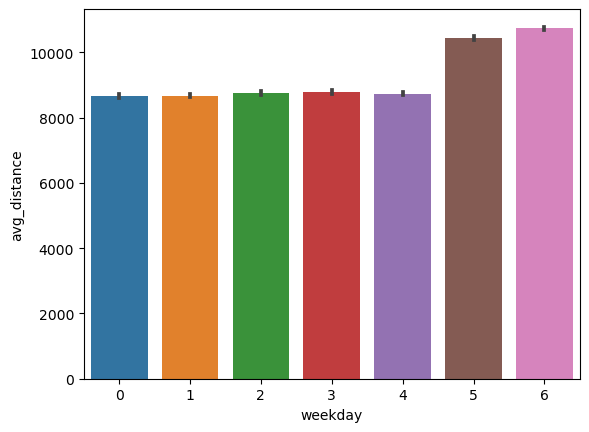

In [67]:
sns.barplot(x='weekday', y='avg_distance', data=df)

### (4) 월별

* 차량 운행수

<AxesSubplot:xlabel='year', ylabel='driving_car'>

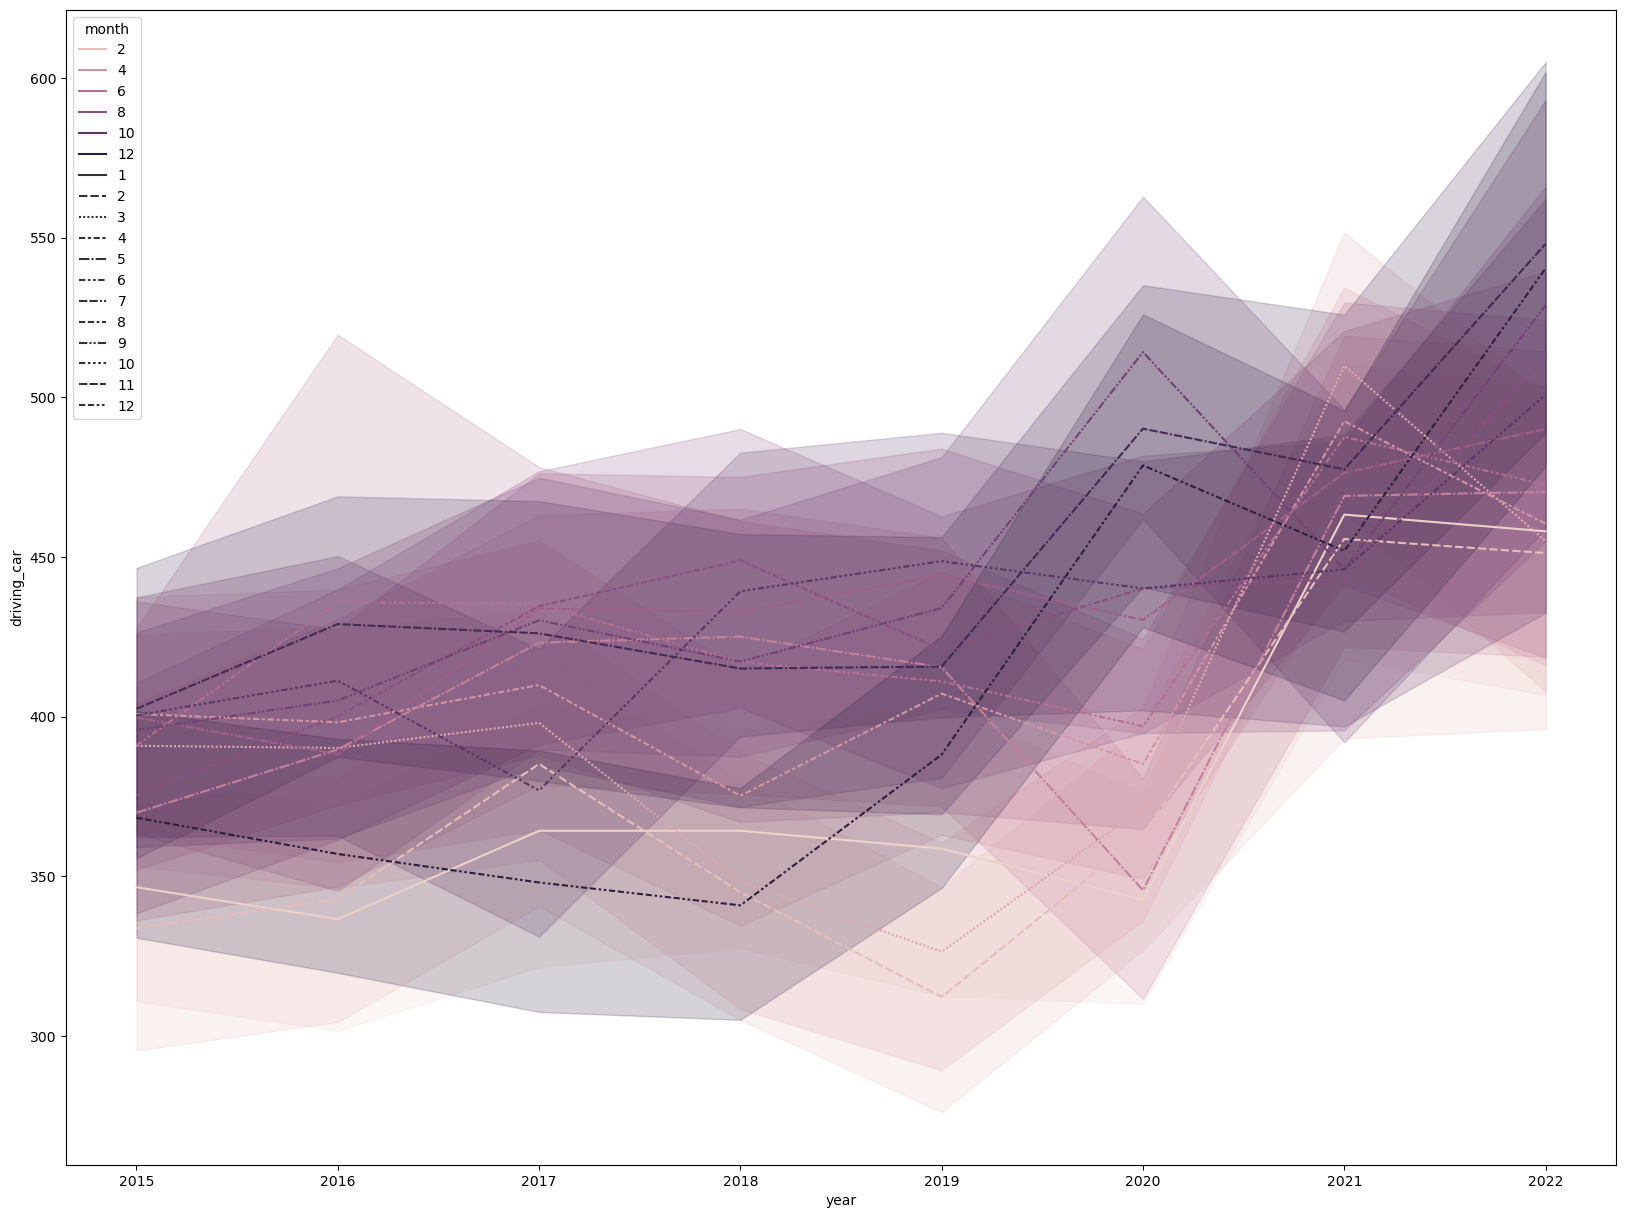

In [79]:
plt.figure(figsize=(20,15))
sns.lineplot(data=df, x="year", y="driving_car", hue="month",style='month')

* 접수건, 탑승건

In [80]:
df.groupby('month')['reception','boarding'].mean()

C:\Users\User\AppData\Local\Temp\ipykernel_20020\884653957.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby('month')['reception','boarding'].mean()


,reception,boarding
month,,
1,3681.826613,3092.262097
2,3582.097345,3032.075221
3,3691.330645,3168.822581
4,3964.479167,3358.558333
5,3910.572581,3278.435484
6,4001.304167,3372.837500
7,4099.637097,3437.862903
8,4014.963710,3350.512097
9,3962.508333,3287.950000


* 대기시간

In [82]:
df.groupby('month')['avg_waiting'].mean()

month
1     33.393952
2     34.419469
3     35.182258
4     39.628750
5     41.181452
6     40.381667
7     40.033468
8     38.568952
9     42.364167
10    44.480242
11    47.063333
12    46.713306
Name: avg_waiting, dtype: float64

* 운임

In [83]:
df.groupby('month')['avg_fee'].mean()

month
1     2279.616935
2     2296.623894
3     2291.600806
4     2310.712500
5     2326.209677
6     2308.991667
7     2290.407258
8     2286.189516
9     2331.583333
10    2334.774194
11    2309.175000
12    2286.104839
Name: avg_fee, dtype: float64

* 이동거리

In [84]:
df.groupby('month')['avg_distance'].mean()

month
1     9048.161290
2     9221.039823
3     9129.588710
4     9313.458333
5     9462.447581
6     9292.650000
7     9151.556452
8     9127.072581
9     9493.016667
10    9485.576613
11    9251.379167
12    9074.028226
Name: avg_distance, dtype: float64

### (5) 연도별

* 차량 운행수

In [85]:
df.groupby('year')['driving_car'].mean()

year
2015    381.468493
2016    390.314208
2017    405.397260
2018    397.758904
2019    399.068493
2020    416.521858
2021    468.271233
2022    490.898630
Name: driving_car, dtype: float64

* 대기시간

In [86]:
df.groupby('year')['avg_waiting'].mean()

year
2015    34.059452
2016    38.272404
2017    44.143014
2018    56.322192
2019    53.455616
2020    28.045082
2021    30.720822
2022    37.466027
Name: avg_waiting, dtype: float64

In [95]:
df['date'] = df['date'].dt.strftime('%Y-%m-%d')

## 3.데이터 구조 만들기

* **세부요구사항**
    * 조건 : 
        * 목표 : 전날 저녁, 다음날 평균 대기시간을 예측하고자 합니다.
        * 날씨 데이터는 실제 측정값이지만, 다음 날에 대한 예보 데이터로 간주합니다. 
            * 예를 들어, 
                * 2020-12-23 의 날씨 데이터는 전날(12월22일) 날씨예보 데이터로 간주하여 분석을 수행합니다.
                * 2020-12-22일의 장애인 이동 데이터로 23일의 대기시간을 예측해야 하며, 이때 고려할 날씨데이터는 23일 데이터 입니다.
    * 장애인 이동 데이터를 기준으로 날씨 데이터를 붙입니다.

In [102]:
weather.rename(columns={'Date':'date'},inplace=True)

In [103]:
df1 = pd.merge(df, weather, how='inner', on='date')

In [112]:
df1.iloc[:,12:]=df1.iloc[:,12:].shift(-1)

In [116]:
df1.dropna(axis=0, inplace=True)

In [118]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2921 entries, 0 to 2920
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             2921 non-null   object 
 1   driving_car      2921 non-null   int64  
 2   reception        2921 non-null   int64  
 3   boarding         2921 non-null   int64  
 4   avg_waiting      2921 non-null   float64
 5   avg_fee          2921 non-null   int64  
 6   avg_distance     2921 non-null   int64  
 7   week             2921 non-null   UInt32 
 8   year             2921 non-null   int64  
 9   month            2921 non-null   int64  
 10  weekday          2921 non-null   int64  
 11  day              2921 non-null   int64  
 12  temp_max         2921 non-null   float64
 13  temp_min         2921 non-null   float64
 14  rain(mm)         2921 non-null   float64
 15  humidity_max(%)  2921 non-null   float64
 16  humidity_min(%)  2921 non-null   float64
 17  sunshine(MJ/m2

### (1) target 만들기
* 예측하는 날짜, 대기시간(target)으로 기준을 잡습니다.

In [119]:
target = 'avg_waiting'

### (2) 날씨 데이터 붙이기
* merge를 활용합니다. 기준은 운행정보 입니다.

### (3) 새로운 feature를 생성해 봅시다.
* 날짜와 관련된 변수 추가하기 : 요일, 월, 계절, 연도
* 그외 새로운 feature 도출 : 최소 2개 이상
    * 예 : 공휴일, 최근 7주일간의 평균 대기시간, 탑승률 등

#### 1) 날짜와 관련된 변수 추가하기 : 요일, 월, 계절, 연도
* 요일 이름, 계절이름, 월 이름으로 만드는 경우에는, 변수를 pd.Categorical로 범주형을 만들면서 순서를 지정하는 것이 이후 그래프를 그릴 때 순서대로 표현할 수 있습니다.


#### 2) 공휴일 정보
* workalendar 패키지를 설치하고, 대한민국 공휴일 정보를 끌어와 봅시다.

* 휴무일 데이터 패키지 설치

In [120]:
!pip install workalendar

     -------------------------------------- 210.7/210.7 kB 1.6 MB/s eta 0:00:00
     -------------------------------------- 341.8/341.8 kB 4.3 MB/s eta 0:00:00
     ---------------------------------------- 47.9/47.9 kB ? eta 0:00:00
     ---------------------------------------- 5.8/5.8 MB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pymeeus: filename=PyMeeus-0.5.12-py3-none-any.whl size=732001 sha256=eacf665120699c51ba92a2e3e49ee55329f2108e2d686f009a2c7a0a52303a63
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\04\1f\e5\8dd0c661cd8d252817655dc14a84f7ae045d6616594145aa81
Successfully built pymeeus


* 간단 사용법

In [131]:
from workalendar.asia import SouthKorea
cal = SouthKorea()
holiday = pd.DataFrame(cal.holidays(2015))

* 휴무일 데이터셋 만들기 2015 ~ 2022
* 실제로 휴무일에 해당하지만 workalendar 라이브러리에 없는 날짜는 직접 추가해봅시다.
    * 휴무일 장애인 콜택시의 접수건 변화에 대한 특징을 찾아 이를 바탕으로 데이터를 조회하여 찾아볼 수 있음

In [132]:
for year in range(2016, 2023):
    temp = pd.DataFrame(cal.holidays(year))
    holiday = pd.concat([holiday, temp])

* 기존 데이터에 휴무일 정보 결합하기.
* 휴무일이 아닌 날짜는 0으로 저장하시오.

In [171]:
holiday.reset_index(inplace=True)

In [173]:
holiday.drop('index', inplace=True, axis=1)

In [178]:
holiday[0] = holiday[0].astype(str)

In [193]:
holiday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       120 non-null    object
 1   1       120 non-null    object
dtypes: object(2)
memory usage: 2.0+ KB


In [191]:
df1['date'] = df1['date'].astype(str)

In [195]:
ko_holiday = list(holiday[0])

In [196]:
def is_holiday(date):
    if date in ko_holiday:
        return 1
    else:
        return 0

In [197]:
df1['is_holiday'] = df1['date'].apply(lambda x: is_holiday(x))

#### 3) 7일 이동평균 대기시간
* rolling().mean() 사용

In [201]:
df1.loc[df1['is_holiday']==1].count()

date               119
driving_car        119
reception          119
boarding           119
avg_waiting        119
avg_fee            119
avg_distance       119
week               119
year               119
month              119
weekday            119
day                119
temp_max           119
temp_min           119
rain(mm)           119
humidity_max(%)    119
humidity_min(%)    119
sunshine(MJ/m2)    119
is_holiday         119
dtype: int64

#### 4) 탑승률

In [204]:
df1['boarding_rate'] = df1['boarding']/df1['reception']

## 4.데이터 저장
* **세부요구사항**
    * joblib 을 사용하여 작업 경로에 정리한 데이터프레임을 저장합니다.
        * 저장파일이름 : data1.pkl

In [205]:
df1

,date,driving_car,reception,boarding,avg_waiting,avg_fee,avg_distance,week,year,month,weekday,day,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),is_holiday,boarding_rate
0,2015-01-01,213,1023,924,23.2,2427,10764,1,2015,1,3,1,-2.0,-8.9,0.0,63.0,28.0,9.07,1,0.903226
1,2015-01-02,420,3158,2839,17.2,2216,8611,1,2015,1,4,2,2.4,-9.2,0.0,73.0,37.0,8.66,0,0.898987
2,2015-01-03,209,1648,1514,26.2,2377,10198,1,2015,1,5,3,8.2,0.2,0.0,89.0,58.0,5.32,0,0.918689
3,2015-01-04,196,1646,1526,24.5,2431,10955,1,2015,1,6,4,7.9,-0.9,0.0,95.0,52.0,6.48,0,0.927096
4,2015-01-05,421,4250,3730,26.2,2214,8663,2,2015,1,0,5,4.1,-7.4,3.4,98.0,29.0,10.47,0,0.877647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2916,2022-12-26,603,5555,4605,39.2,2163,7889,52,2022,12,0,26,3.0,-7.3,0.0,86.0,51.0,10.25,0,0.828983
2917,2022-12-27,669,5635,4654,44.4,2198,8178,52,2022,12,1,27,-0.3,-5.4,0.1,92.0,40.0,10.86,0,0.825909
2918,2022-12-28,607,5654,4648,44.8,2161,7882,52,2022,12,2,28,1.7,-7.8,0.0,71.0,34.0,10.88,0,0.822073
2919,2022-12-29,581,5250,4247,52.5,2229,8433,52,2022,12,3,29,2.1,-4.0,0.0,87.0,38.0,10.84,0,0.808952


In [206]:
import joblib
joblib.dump(df1,'data1.pkl')

['data1.pkl']